# hw_8.2: OCR

In [ ]:
!nvidia-smi -L
!lscpu 
!echo 'RAM available:' && free -h --si | awk  '/Mem:/{print $2}'
!echo 'Space available: ' && df -h / | awk '{print $4}'
!nvidia-smi

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-33b565f6-e1a3-2666-f944-2b6624859c75)
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               85
Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz
Stepping:            3
CPU MHz:             2000.168
BogoMIPS:            4000.33
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            1024K
L3 cache:            39424K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe pop

Сниппет для установки окружения под A100 (другая версия CUDA)

In [ ]:
# import subprocess
# subprocess = subprocess.Popen("nvidia-smi -L", shell=True, stdout=subprocess.PIPE)
# subprocess_return = str(subprocess.stdout.read())
# if subprocess_return.find('A100') != -1:
#   # to work with A100
#   !pip install torch==1.9.1+cu111 torchvision==0.10.1+cu111 torchaudio==0.9.1 -f https://download.pytorch.org/whl/torch_stable.html

## Download data

In [ ]:
# !curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
# !unzip -qq captcha_images_v2.zip && rm -rf captcha_images_v2.zip

## Imports

In [ ]:
!pip -qq install ipyplot

In [ ]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import functional as F

import numpy as np
from PIL import Image
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

import albumentations as A

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

from glob import glob
from tqdm.notebook import tqdm

## Settings

In [ ]:
dataset_path = '/content/captcha_images_v2'
imgs_paths = glob(dataset_path + '/*.png')
imgs_paths

batch_size = 16
img_width = 200
img_height = 50

num_workers = 2
epochs = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'


## Dataset

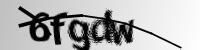

In [ ]:
Image.open(imgs_paths[0])

In [ ]:
aug = A.Compose(
    [A.Normalize(always_apply=True)]
)
# aug(image=np.array(Image.open(imgs_paths[0]).convert('RGB')))

In [ ]:
class OCR_Dataset:
  def __init__(self, imgs_path, labels, img_width, img_height):
    self.imgs_path = imgs_path
    self.labels = labels
    self.img_width = img_width
    self.img_height = img_height

    self.aug = A.Compose(
       [A.Normalize(always_apply=True),]
    )

  def __len__(self):
    return len(self.imgs_path)

  def __getitem__(self, idx):
    labels = self.labels[idx]
    img = Image.open(self.imgs_path[idx])
    img = img.convert('RGB')
    img = img.resize((self.img_width, self.img_height), resample=Image.BILINEAR)

    img = np.array(img)
    augmented_img = self.aug(image=img)
    img = np.transpose(img, (2,0,1)).astype(np.float32)

    return {'images': torch.tensor(img, dtype=torch.float),
            'labels': torch.tensor(labels, dtype=torch.long)}


Обучающий датасет.


        WARNING! Google Colab Environment detected!
        You might encounter issues while running in Google Colab environment.
        If images are not displaying properly please try setting `base_64` param to `True`.
        



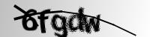
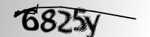
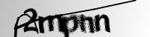
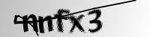
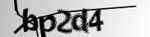
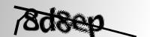
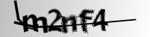
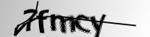
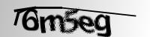
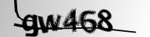
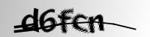
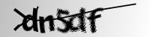
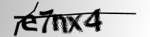
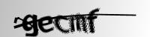
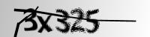
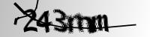
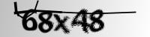
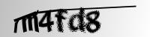
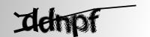
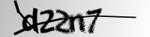
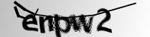
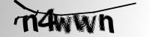
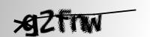
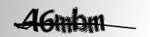
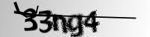
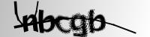
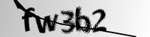
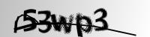
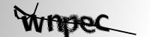
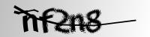


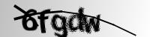
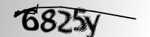
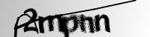
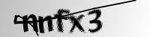
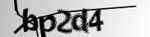
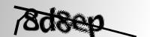
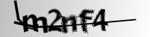
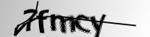
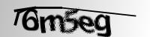
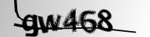
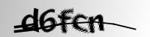
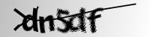
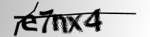
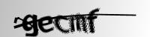
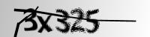
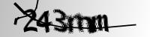
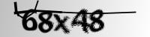
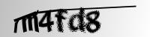
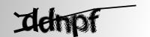
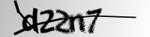
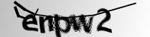
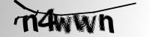
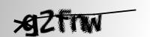
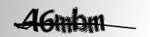
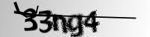
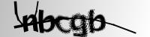
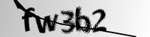
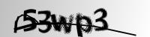
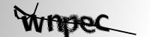
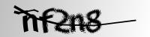

In [ ]:
from ipyplot import plot_images
from glob import glob
plot_images(glob(dataset_path +'/*.png'), force_b64=True)

Сделаем целевой датасет из названий файлов.

In [ ]:
# возьмем имена файлов без расширений
labels_orig = [i.split('/')[-1].split('.')[0] for i in imgs_paths]
# labels_orig

# разобъем каждое имя на список длиной 5
labels = [[i for i in x] for x in labels_orig]
# print(labels)

# тоже самое плоским списком
labels_flat = [i for sublist in labels for i in sublist]
# labels_flat

Энкодер для кодирования классов цифрами.

In [ ]:
# label encoding gives numbers: ['x','4','4'..]. --> array([17,2,2,...])
from sklearn import preprocessing
labels_enc = preprocessing.LabelEncoder()
labels_enc.fit(labels_flat)

#get classes similar with np.unique
print(labels_enc.classes_)
print(len(labels_enc.classes_))

['2' '3' '4' '5' '6' '7' '8' 'b' 'c' 'd' 'e' 'f' 'g' 'm' 'n' 'p' 'w' 'x'
 'y']
19


Получилось 19+1 классов (вместе с классом 0 - неопределенный)

In [ ]:
lbls_enc = [labels_enc.transform(x) for x in labels]
# lbls_enc

# increment by 1 because we use 0 for unknown
lbls_enc = np.array(lbls_enc) + 1
# lbls_enc[:10]

#get unique values
print(np.unique(labels_flat))

# get classes
print(labels_enc.classes_)

['2' '3' '4' '5' '6' '7' '8' 'b' 'c' 'd' 'e' 'f' 'g' 'm' 'n' 'p' 'w' 'x'
 'y']
['2' '3' '4' '5' '6' '7' '8' 'b' 'c' 'd' 'e' 'f' 'g' 'm' 'n' 'p' 'w' 'x'
 'y']


# Train-Test split

Разобьем датасет.

In [ ]:
# split the data
from sklearn.model_selection import train_test_split
(train_imgs,
 val_imgs,
 train_labels,
 val_labels,
 train_orig_labels,
 val_orig_labels) = train_test_split(imgs_paths, lbls_enc, labels_orig, test_size=0.1, random_state=42)

# print examples
print('train_imgs: ',train_imgs[0])
print('train labels: ',train_labels[0])

train_imgs:  /content/captcha_images_v2/w46ep.png
train labels:  [17  3  5 11 16]


Подготовим загрузчик.

In [ ]:
# init dataset and dataloader
train_dataset = OCR_Dataset(imgs_path=train_imgs,
                            labels=train_labels,
                            img_width=img_width,
                            img_height=img_height)

train_loader = DataLoader(train_dataset, batch_size, num_workers=num_workers, shuffle=True)

# init val dataset and dataloader
val_dataset = OCR_Dataset(imgs_path=val_imgs,
                            labels=val_labels,
                            img_width=img_width,
                            img_height=img_height)

val_loader = DataLoader(val_dataset, batch_size, num_workers=num_workers, shuffle=False)

(3, 50, 200)
(50, 200, 3)


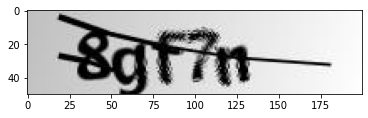

In [ ]:
# test loader
batch = iter(train_loader).next()
batch['images'][0]

test_img = batch['images'][0].numpy()
print(test_img.shape)
test_img = np.transpose(test_img,(1,2,0))
print(test_img.shape)

plt.imshow(test_img/255)

## Model OCR

In [ ]:
class OCR_Model(nn.Module):
    def __init__(self, num_characters):
        super().__init__()
        # Conv-1
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3, 3), padding=(1, 1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2, 2))
        # Conv-2
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding=(1, 1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2, 2))
        # FC
        self.linear1 = nn.Linear(768, 768//2)
        self.linear2 = nn.Linear(768//2, 200)
        self.linear3 = nn.Linear(200, 64)
        # GRU
        self.gru = nn.GRU(64, 32, bidirectional=True,
                          num_layers=2,
                          dropout=0.2,
                          batch_first=True)
        self.output = nn.Linear(64, num_characters+1)

    def forward(self, images, labels):
        bs, channels, height, width = images.size()

        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        # have to swap channels and rnn : bs,c,h,w --> bs,w,c,h
        x = x.permute(0, 3, 1, 2)

        # flattening for linear layer
        x = x.view(bs, x.size(1), -1)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        log_softmax_values = F.log_softmax(x, 2)

        input_lenght = torch.full(
            size=(bs,),
            fill_value=log_softmax_values.size(0),
            dtype=torch.int32)

        output_lenght = torch.full(
            size=(bs,),
            fill_value=labels.size(1),
            dtype=torch.int32)

        loss = nn.CTCLoss(blank=0)(
            log_softmax_values,
            labels,
            input_lenght,
            output_lenght
        )

        return x, loss

In [ ]:
# model = OCR_Model(num_characters=19)
# model.to(device)
# img = torch.rand(5,3,img_height, img_width).to(device)
# label = torch.randint(1,20,(5,5,)).to(device)
# preds = model(img,label)
# print(preds)

In [ ]:
def decode_preds(preds, encoder):
  preds = preds.permute(1,0,2)
  preds = torch.softmax(preds,2)
  preds = torch.argmax(preds,2)
  preds = preds.detach().cpu().numpy()

  preds_list = []

  for i in range(preds.shape[0]):
    tmp = []
    for j in preds[i,:]:
      j = j-1
      if j == -1:
        tmp.append('*')
      else:
        tmp.append(encoder.inverse_transform([j])[0])
    element = ''.join(tmp)
    preds_list.append(element)
  return preds_list

In [ ]:
def decode_preds2(preds, encoder):
  preds = preds.permute(1,0,2)
  preds = torch.softmax(preds,2)
  preds = torch.argmax(preds,2)
  preds = preds.detach().cpu().numpy()

  preds_list = []

  for line in preds:
    seq = []
    for i in range(1, len(line)):
      curr = line[i]
      prev = line[i-1]
      if curr != 0 and curr != prev:
          seq.append(encoder.inverse_transform([curr-1])[0])
    preds_list.append(''.join(seq))
  return preds_list

In [ ]:
def decode_preds3(preds, encoder):
  preds = preds.permute(1,0,2)
  preds = torch.softmax(preds,2)
  preds = torch.argmax(preds,2)
  preds = preds.detach().cpu().numpy()

  preds_list = []

  for i in range(preds.shape[0]):
    tmp = []
    for j in preds[i,:]:
      j = j-1
      if j == -1:
        tmp.append('')
      else:
        tmp.append(encoder.inverse_transform([j])[0])
    element = ''.join(tmp)
    preds_list.append(element)
  return preds_list

In [ ]:
def ground_truth(array):
    array = labels_enc.inverse_transform(array - 1).tolist()
    return ''.join(array)

## Train model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OCR_Model(num_characters=19)

model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

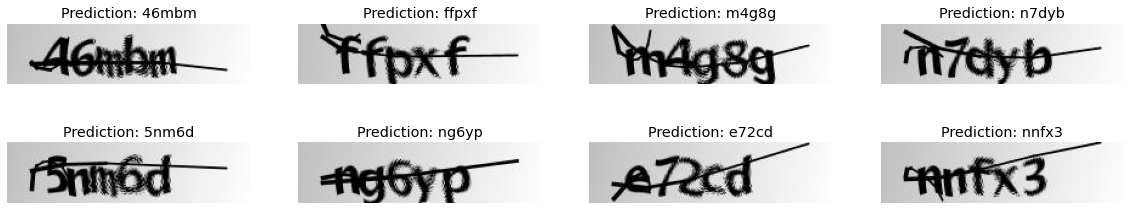

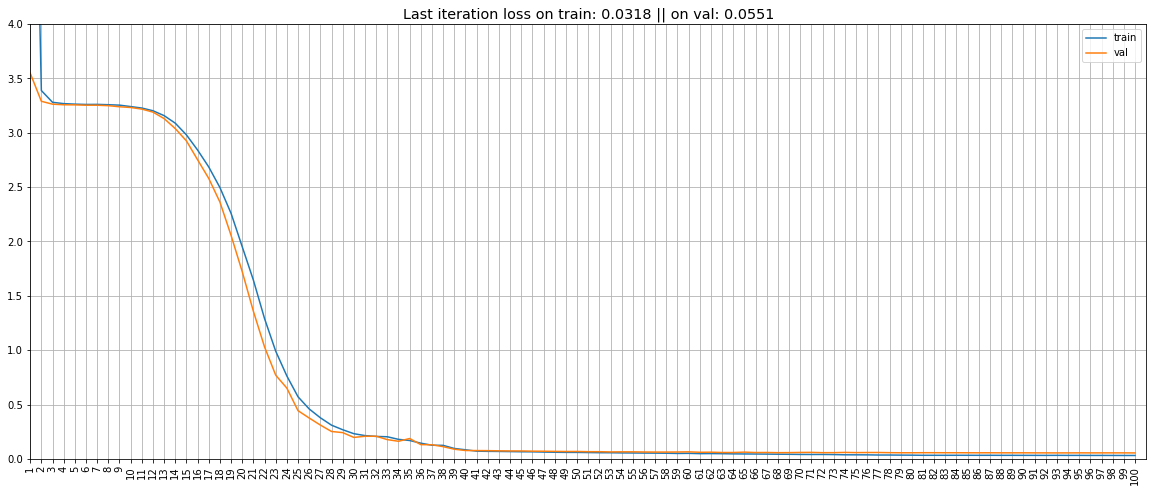

In [ ]:
losses = {'train_1': [], 'val_1': [], 'train_2': [], 'val_2': []}

for epoch in range(epochs):  # tqdm(, 'Epoch'):
    # train
    avg_loss_train = 0
    final_preds = []

    model.train()

    # tqdm_loop = tqdm(train_loader, 'Step', total=len(train_loader))
    for data in train_loader:  # tqdm_loop:
        imgs = data['images'].to(device)
        labels = data['labels'].to(device)

        optimizer.zero_grad()

        preds, loss = model(imgs, labels)
        loss.backward()
        optimizer.step()

        avg_loss_train += loss.item() / len(train_loader)
        final_preds.append(preds)

    scheduler.step()
    # print(f'Train loss: {avg_loss_train:9.4f}')
    losses['train_1'].append(avg_loss_train)

    # val
    with torch.no_grad():
        avg_loss_val = 0
        final_preds = []

        model.eval()
        # tqdm_loop = tqdm(val_loader, 'Step', total=len(val_loader))
        for data in val_loader: # tqdm_loop:
            imgs = data['images'].to(device)
            labels = data['labels'].to(device)
            preds, loss = model(imgs, labels)

            avg_loss_val += loss.item() / len(val_loader)

            decoded_preds = decode_preds2(preds, encoder=labels_enc)
            final_preds.extend(decoded_preds)

    # print(f'Val loss: {avg_loss_val:9.4f}')
    losses['val_1'].append(avg_loss_val)

    # Visualize, compare ground truth vs output
    clear_output(wait=True)
    plt.subplots(figsize=(20, 4))
    for k in range(8):
        plt.subplot(2, 4, k+1)

        test_img = data['images'][k].numpy()
        test_img = np.transpose(test_img, (1, 2, 0))

        plt.imshow(test_img/255)
        plt.title('Prediction: %s' % decoded_preds[k], fontsize='x-large')
        plt.axis('off')

    # Plotting a loss graph for train and validation
    plt.figure(figsize=(20, 8))
    plt.plot(losses['train_1'], label="train")
    plt.plot(losses['val_1'], label="val")
    plt.title('Last iteration loss on train: %.4f || on val: %.4f' % (avg_loss_train, avg_loss_val), fontsize='x-large')
    plt.ylim(0, 4)
    plt.xlim(0, epochs)
    plt.xticks(range(epochs), range(1, epochs+1), rotation=90)
    plt.grid()
    plt.legend()
    plt.show()

## Model OCR w/ ResNet18 as Backbone

In [ ]:
from fastai.vision import create_body, models

In [ ]:
class OCR_Model_Backbone(nn.Module):
    def __init__(self, num_characters):
        super().__init__()
        # ResNet18 as backbone
        self.bb = create_body(models.resnet18, pretrained=True)
        # FC
        self.linear1 = nn.Linear(512, 256)
        self.linear2 = nn.Linear(256, 200)
        self.linear3 = nn.Linear(200, 64)
        # GRU
        self.gru = nn.GRU(64, 32, bidirectional=True,
                          num_layers=2,
                          dropout=0.2,
                          batch_first=True)
        self.output = nn.Linear(64, num_characters+1)

    def forward(self, images, labels):
        bs, channels, height, width = images.size()
        x = self.bb(images)

        # flattening for linear layer
        x = x.view(bs, x.size(1), -1)

        x = x.permute(0, 2, 1)

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        log_softmax_values = F.log_softmax(x, 2)

        input_lenght = torch.full(
            size=(bs,),
            fill_value=log_softmax_values.size(0),
            dtype=torch.int32)

        output_lenght = torch.full(
            size=(bs,),
            fill_value=labels.size(1),
            dtype=torch.int32)

        loss = nn.CTCLoss(blank=0)(
            log_softmax_values,
            labels,
            input_lenght,
            output_lenght
        )

        return x, loss

# Train model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = OCR_Model_Backbone(num_characters=19)

model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

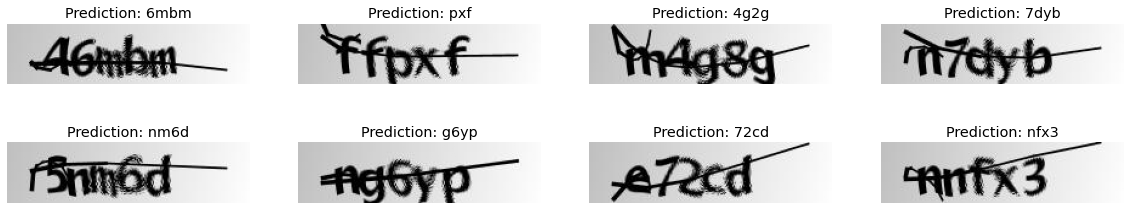

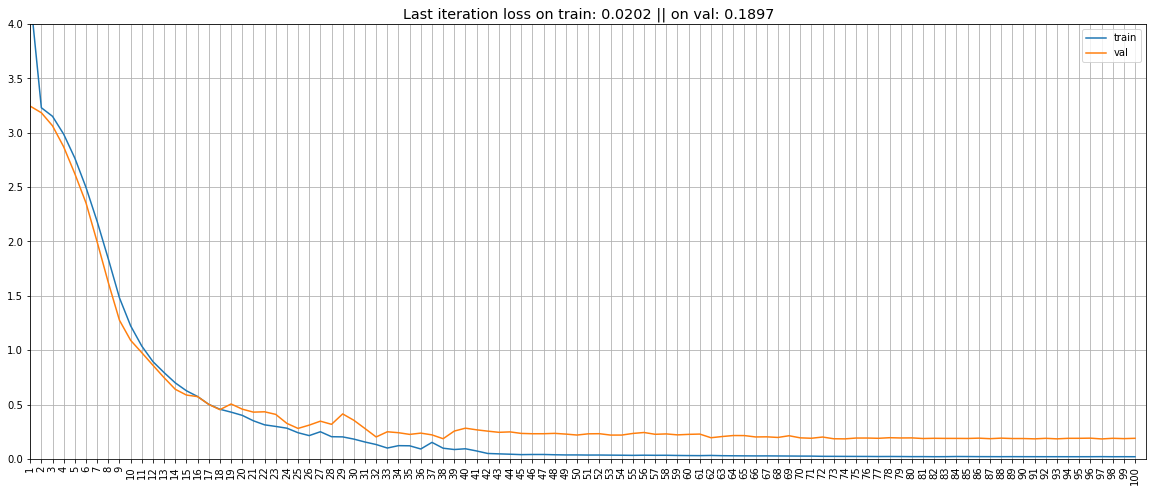

In [ ]:
losses['train_2'] = []
losses['val_2'] = []

for epoch in range(epochs):
    # train
    avg_loss_train = 0
    final_preds = []

    model.train()

    for data in train_loader:
        imgs = data['images'].to(device)
        labels = data['labels'].to(device)

        optimizer.zero_grad()

        preds, loss = model(imgs, labels)
        loss.backward()
        optimizer.step()

        avg_loss_train += loss.item() / len(train_loader)
        final_preds.append(preds)

    scheduler.step()
    losses['train_2'].append(avg_loss_train)

    # val
    with torch.no_grad():
        avg_loss_val = 0
        final_preds = []

        model.eval()
        for data in val_loader:
            imgs = data['images'].to(device)
            labels = data['labels'].to(device)
            preds, loss = model(imgs, labels)

            avg_loss_val += loss.item() / len(val_loader)

            decoded_preds = decode_preds2(preds, encoder=labels_enc)
            final_preds.extend(decoded_preds)

    losses['val_2'].append(avg_loss_val)

    # Visualize, compare ground truth vs output
    clear_output(wait=True)
    plt.subplots(figsize=(20, 4))
    for k in range(8):
        plt.subplot(2, 4, k+1)

        test_img = data['images'][k].numpy()
        test_img = np.transpose(test_img, (1, 2, 0))

        plt.imshow(test_img/255)
        plt.title('Prediction: %s' % decoded_preds[k], fontsize='x-large')
        plt.axis('off')

    # Plotting a loss graph for train and validation
    plt.figure(figsize=(20, 8))
    plt.plot(losses['train_2'], label="train")
    plt.plot(losses['val_2'], label="val")
    plt.title('Last iteration loss on train: %.4f || on val: %.4f' % (avg_loss_train, avg_loss_val), fontsize='x-large')
    plt.ylim(0, 4)
    plt.xlim(0, epochs)
    plt.xticks(range(epochs), range(1, epochs+1), rotation=90)
    plt.grid()
    plt.legend()
    plt.show()

## Recap

1. Сделана визуализация. Можно оценить качество предсказания по последнему батчу, а также по кривым потерь на обучении и валидации.

2. Во второй модели для экстракции признаков (backbone) использована сеть ResNet18. 

3. Обе модели выходят на плато около 40 эпохи, при этом модель с бекбоном показывает переобучение.

4. Использование более сложной архитектуры себя не оправдало. Получить ошибку ниже, чем на оригинальной модели не удалось (0.1838 против 0.0551).

5. Есть проблема с размерностями, которую пока не понятно как решать. На выходе из ResNet18 получается вектор длиной 14 символов (в оригинале 50). Для корректного отображения предиктов пришлось упростить декодер.

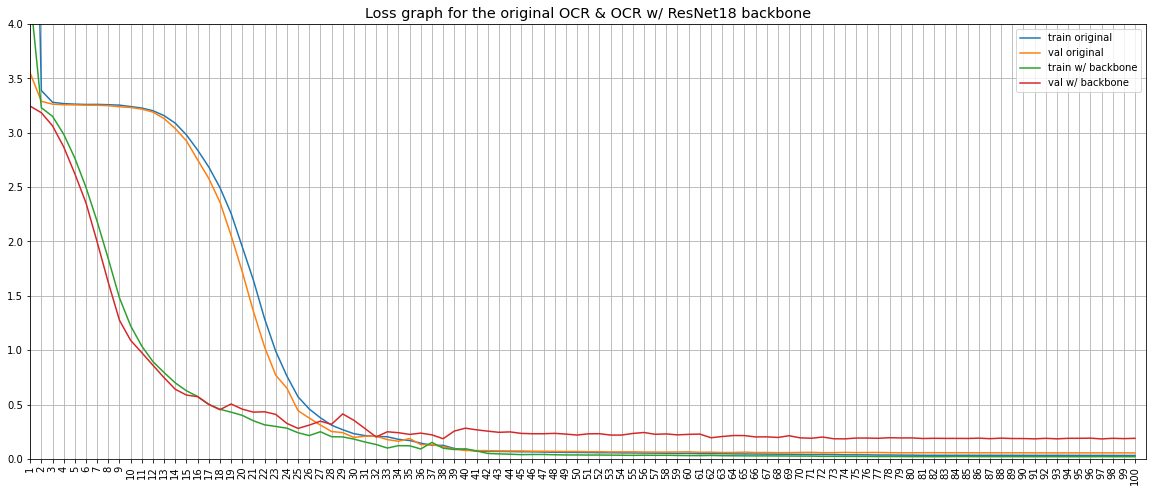

In [ ]:
# Plotting a loss graph for train and validation
plt.figure(figsize=(20, 8))
plt.plot(losses['train_1'], label="train original")
plt.plot(losses['val_1'], label="val original")
plt.plot(losses['train_2'], label="train w/ backbone")
plt.plot(losses['val_2'], label="val w/ backbone")
plt.title('Loss graph for the original OCR & OCR w/ ResNet18 backbone', fontsize='x-large')
plt.ylim(0, 4)
plt.xlim(0, epochs)
plt.xticks(range(epochs), range(1, epochs+1), rotation=90)
plt.grid()
plt.legend()
plt.show()